# <center><em>IITH Hackathon: Driver Fault Classification</em></center>

___

<a href='https://www.kaggle.com/c/Foml-2021/overview'><img src='header.png'/></a>
___

### Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
import xgboost as xgb

### Loading the training data

In [2]:
df = pd.read_csv("train_accident.csv",parse_dates = ['Crash Date/Time'])
df.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location,Fault
0,MP060D,10196,Montgomery County Police,Injury Crash,2017-06-05 16:27:00,Maryland (State),OLD HUNDRED RD,County,THURSTON RD,12305 SHOREFIELD RD,...,No,No,2005,GMC,TRUCK,NO MISUSE,39.263378,-77.344203,3.6383 7.4233,1
1,MP000X,20080,Montgomery County Police,Injury Crash,2020-02-22 10:00:00,County,JANET RD,County,FLACK ST,NaN,...,No,Yes,2018,FORD,FIESTA,NO MISUSE,39.068913,-77.063227,3.0862 7.324,1
2,MP070N,10103,Montgomery County Police,Property Damage Crash,2017-06-11 08:21:00,Maryland (State),COLESVILLE RD,Maryland (State),STRUC #15082,NaN,...,No,No,2016,NEW FLYER,TBU,NO MISUSE,38.993578,-77.032718,3.9583 7.3783,0
3,MP130Y,10208,Montgomery County Police,Injury Crash,2019-05-10 07:30:00,County,PARKLAND DR,County,FRANKFORT DR,NaN,...,No,No,2001,CHEV,SUBURBAN,OTHER,39.083480,-77.086933,"3.84,-70633",1
4,MP770Y,1091,Montgomery County Police,Injury Crash,2016-08-02 17:00:00,Maryland (State),OLD GEORGETOWN RD,County,MCKINLEY ST,NaN,...,No,No,2013,KIA,RIO,NO MISUSE,38.996942,-77.109168,3.9917 7.0183,0


In [3]:
df.shape

(51490, 42)

### Pre-processing and EDA of the training data

In [4]:
def extract(data):
    return data[:1]

df['Report Category'] = df['Report Number'].apply(extract)

In [5]:
df['Report Category'].value_counts()

M    45104
D     3835
E     2208
H      343
Name: Report Category, dtype: int64

In [6]:
df.isnull().sum()

Report Number                         0
Local Case Number                  6453
Agency Name                           0
ACRS Report Type                      0
Crash Date/Time                       0
Route Type                         4968
Road Name                          4502
Cross-Street Type                  5019
Cross-Street Name                  4522
Off-Road Description              44540
Municipality                      43923
Related Non-Motorist              47842
Collision Type                      299
Weather                            4029
Surface Condition                  5879
Light                               704
Traffic Control                    7774
Driver Substance Abuse             9095
Non-Motorist Substance Abuse      48106
Person ID                             0
Injury Severity                       0
Circumstance                      39738
Drivers License State              2528
Vehicle ID                            0
Vehicle Damage Extent               397


In [7]:
# dropped because of high occurence of nan values
df.drop(['Off-Road Description','Municipality','Related Non-Motorist','Non-Motorist Substance Abuse','Circumstance','Person ID','Vehicle ID'], axis = 1, inplace = True)


In [8]:
df.shape   

(51490, 36)

In [9]:
df.isnull().sum()

Report Number                         0
Local Case Number                  6453
Agency Name                           0
ACRS Report Type                      0
Crash Date/Time                       0
Route Type                         4968
Road Name                          4502
Cross-Street Type                  5019
Cross-Street Name                  4522
Collision Type                      299
Weather                            4029
Surface Condition                  5879
Light                               704
Traffic Control                    7774
Driver Substance Abuse             9095
Injury Severity                       0
Drivers License State              2528
Vehicle Damage Extent               397
Vehicle First Impact Location       222
Vehicle Second Impact Location      234
Vehicle Body Type                   785
Vehicle Movement                    198
Vehicle Continuing Dir             1129
Vehicle Going Dir                  1113
Speed Limit                           0


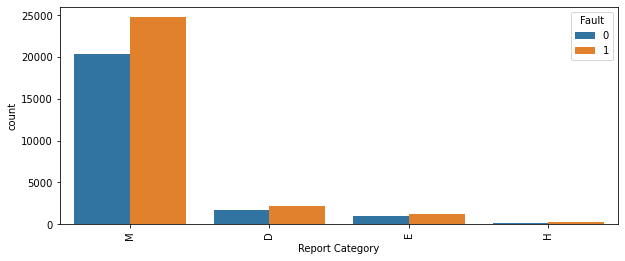

In [10]:
plt.figure(figsize = (10,4))
sns.countplot(data = df, x = 'Report Category', hue = 'Fault')
#plt.ylim(0,500)
plt.xticks(rotation = 90)
plt.show()

In [11]:
df['Crash_day'] = df['Crash Date/Time'].dt.day
df['Crash_hour'] = df['Crash Date/Time'].dt.hour
df['Crash_month'] = df['Crash Date/Time'].dt.month
df['Crash_year'] = df['Crash Date/Time'].dt.year
df['Crash_day_of_week'] = df['Crash Date/Time'].dt.dayofweek
df.drop('Crash Date/Time',axis='columns', inplace=True)

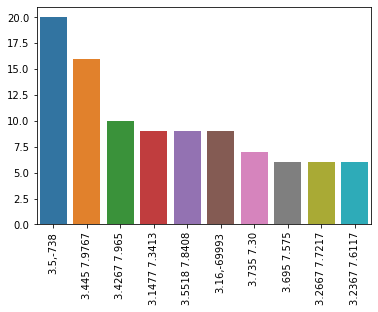

In [12]:
sns.barplot(data = df, x = df['Location'].value_counts()[:10].index, y = df['Location'].value_counts()[:10].values)
plt.xticks(rotation = 90)
plt.show()

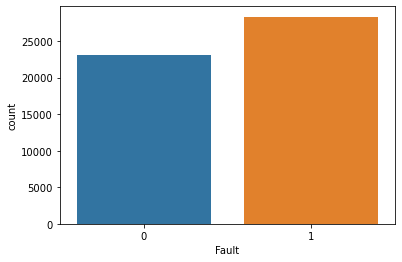

In [13]:
# almost balanced class label
sns.countplot(data = df, x = 'Fault')
plt.show()

In [14]:
# let's check latitude and longitude value ranges

In [15]:
df[(df['Latitude'] < -90) | (df['Latitude'] > 90)] 

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Collision Type,Weather,...,Latitude,Longitude,Location,Fault,Report Category,Crash_day,Crash_hour,Crash_month,Crash_year,Crash_day_of_week


In [16]:
df[(df['Longitude'] < -180) | (df['Longitude'] > 180)] 

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Collision Type,Weather,...,Latitude,Longitude,Location,Fault,Report Category,Crash_day,Crash_hour,Crash_month,Crash_year,Crash_day_of_week


In [17]:
df['Location'] = df['Location'].str.replace(',',' ')
new = df['Location'].str.split(" ", n = 1, expand = True)

df['Location_x'] = new[0]
df['Location_y'] = new[1]
df['Location_x'] = df['Location_x'].astype(float)
df['Location_y'] = df['Location_y'].astype(float)

df.drop('Location', axis = 1, inplace = True)

In [18]:
df.shape

(51490, 41)

In [19]:
drop_columns = ['Report Number']

# drivers license state, local case number, report number removed

In [20]:
df.drop(df[drop_columns], axis = 1, inplace = True)

In [21]:
df.shape

(51490, 40)

In [22]:
df.head()

,Local Case Number,Agency Name,ACRS Report Type,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Collision Type,Weather,Surface Condition,...,Longitude,Fault,Report Category,Crash_day,Crash_hour,Crash_month,Crash_year,Crash_day_of_week,Location_x,Location_y
0,10196,Montgomery County Police,Injury Crash,Maryland (State),OLD HUNDRED RD,County,THURSTON RD,SINGLE VEHICLE,CLEAR,WET,...,-77.344203,1,M,5,16,6,2017,0,3.6383,7.4233
1,20080,Montgomery County Police,Injury Crash,County,JANET RD,County,FLACK ST,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,...,-77.063227,1,M,22,10,2,2020,5,3.0862,7.3240
2,10103,Montgomery County Police,Property Damage Crash,Maryland (State),COLESVILLE RD,Maryland (State),STRUC #15082,SAME DIRECTION RIGHT TURN,CLEAR,DRY,...,-77.032718,0,M,11,8,6,2017,6,3.9583,7.3783
3,10208,Montgomery County Police,Injury Crash,County,PARKLAND DR,County,FRANKFORT DR,OTHER,CLOUDY,DRY,...,-77.086933,1,M,10,7,5,2019,4,3.8400,-70633.0000
4,1091,Montgomery County Police,Injury Crash,Maryland (State),OLD GEORGETOWN RD,County,MCKINLEY ST,SAME DIR REAR END,CLEAR,DRY,...,-77.109168,0,M,2,17,8,2016,1,3.9917,7.0183


In [23]:
df.isnull().sum()

Local Case Number                  6453
Agency Name                           0
ACRS Report Type                      0
Route Type                         4968
Road Name                          4502
Cross-Street Type                  5019
Cross-Street Name                  4522
Collision Type                      299
Weather                            4029
Surface Condition                  5879
Light                               704
Traffic Control                    7774
Driver Substance Abuse             9095
Injury Severity                       0
Drivers License State              2528
Vehicle Damage Extent               397
Vehicle First Impact Location       222
Vehicle Second Impact Location      234
Vehicle Body Type                   785
Vehicle Movement                    198
Vehicle Continuing Dir             1129
Vehicle Going Dir                  1113
Speed Limit                           0
Driverless Vehicle                    0
Parked Vehicle                        0


In [24]:
# now converting the nan values to unknowns

In [25]:
df['Agency Name'] = df['Agency Name'].replace('UNKNOWN','Unknown')
df['Agency Name'] = df['Agency Name'].fillna('Unknown')

df['ACRS Report Type'] = df['ACRS Report Type'].replace('UNKNOWN','Unknown')
df['ACRS Report Type'] = df['ACRS Report Type'].fillna('Unknown')

df['Route Type'] = df['Route Type'].replace('UNKNOWN','Unknown')
df['Route Type'] = df['Route Type'].fillna('Unknown')

df['Cross-Street Type'] = df['Cross-Street Type'].replace('UNKNOWN','Unknown')
df['Cross-Street Type'] = df['Cross-Street Type'].fillna('Unknown')

df['Weather'] = df['Weather'].replace('UNKNOWN','Unknown')
df['Weather'] = df['Weather'].fillna('Unknown')

df['Surface Condition'] = df['Surface Condition'].replace('UNKNOWN','Unknown')
df['Surface Condition'] = df['Surface Condition'].fillna('Unknown')

df['Light'] = df['Light'].replace('UNKNOWN','Unknown')
df['Light'] = df['Light'].fillna('Unknown')

df['Traffic Control'] = df['Traffic Control'].replace('UNKNOWN','Unknown')
df['Traffic Control'] = df['Traffic Control'].fillna('Unknown')

df['Driver Substance Abuse'] = df['Driver Substance Abuse'].replace('UNKNOWN','Unknown')
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].fillna('Unknown')

df['Injury Severity'] = df['Injury Severity'].replace('UNKNOWN','Unknown')
df['Injury Severity'] = df['Injury Severity'].fillna('Unknown')

df['Vehicle Damage Extent'] = df['Vehicle Damage Extent'].replace('UNKNOWN','Unknown')
df['Vehicle Damage Extent'] = df['Vehicle Damage Extent'].fillna('Unknown')

df['Vehicle Second Impact Location'] = df['Vehicle Second Impact Location'].replace('UNKNOWN','Unknown')
df['Vehicle Second Impact Location'] = df['Vehicle Second Impact Location'].fillna('Unknown')

df['Vehicle Body Type'] = df['Vehicle Body Type'].replace('UNKNOWN','Unknown')
df['Vehicle Body Type'] = df['Vehicle Body Type'].fillna('Unknown')

df['Vehicle Movement'] = df['Vehicle Movement'].replace('UNKNOWN','Unknown')
df['Vehicle Movement'] = df['Vehicle Movement'].fillna('Unknown')

df['Vehicle Continuing Dir'] = df['Vehicle Continuing Dir'].replace('UNKNOWN','Unknown')
df['Vehicle Continuing Dir'] = df['Vehicle Continuing Dir'].fillna('Unknown')

df['Vehicle Going Dir'] = df['Vehicle Going Dir'].replace('UNKNOWN','Unknown')
df['Vehicle Going Dir'] = df['Vehicle Going Dir'].fillna('Unknown')

df['Equipment Problems'] = df['Equipment Problems'].replace('UNKNOWN','Unknown')
df['Equipment Problems'] = df['Equipment Problems'].fillna('Unknown')

df['Vehicle First Impact Location'] = df['Vehicle First Impact Location'].replace('UNKNOWN','Unknown')
df['Vehicle First Impact Location'] = df['Vehicle First Impact Location'].fillna('Unknown')

df['Collision Type'] = df['Collision Type'].replace('UNKNOWN','Unknown')
df['Collision Type'] = df['Collision Type'].fillna('Unknown')

In [26]:
df.isnull().sum()

Local Case Number                 6453
Agency Name                          0
ACRS Report Type                     0
Route Type                           0
Road Name                         4502
Cross-Street Type                    0
Cross-Street Name                 4522
Collision Type                       0
Weather                              0
Surface Condition                    0
Light                                0
Traffic Control                      0
Driver Substance Abuse               0
Injury Severity                      0
Drivers License State             2528
Vehicle Damage Extent                0
Vehicle First Impact Location        0
Vehicle Second Impact Location       0
Vehicle Body Type                    0
Vehicle Movement                     0
Vehicle Continuing Dir               0
Vehicle Going Dir                    0
Speed Limit                          0
Driverless Vehicle                   0
Parked Vehicle                       0
Vehicle Year             

In [27]:
df.fillna(-1,inplace=True)

In [28]:
df['Local Case Number'] = df['Local Case Number'].str.replace('P','')
df['Local Case Number']= pd.to_numeric(df['Local Case Number'])

In [29]:
df['Local Case Number'].fillna(-1, inplace = True)

In [30]:
df.shape

(51490, 40)

In [31]:
# before running this cell make sure there aren't any nan values 

enc_RN = (df.groupby('Road Name').size()) / len(df)
df['enc_RN'] = df['Road Name'].apply(lambda x : enc_RN[x])

enc_CSN = (df.groupby('Cross-Street Name').size()) / len(df)
df['enc_CSN'] = df['Cross-Street Name'].apply(lambda x : enc_CSN[x])

enc_VMK = (df.groupby('Vehicle Make').size()) / len(df)
df['enc_VM'] = df['Vehicle Make'].apply(lambda x : enc_VMK[x])

enc_VMM = (df.groupby('Vehicle Model').size()) / len(df)
df['enc_VMM'] = df['Vehicle Model'].apply(lambda x : enc_VMM[x])

df.drop(['Road Name','Cross-Street Name','Vehicle Make','Vehicle Model'], axis = 1, inplace = True)

In [32]:
df.head(3)

,Local Case Number,Agency Name,ACRS Report Type,Route Type,Cross-Street Type,Collision Type,Weather,Surface Condition,Light,Traffic Control,...,Crash_hour,Crash_month,Crash_year,Crash_day_of_week,Location_x,Location_y,enc_RN,enc_CSN,enc_VM,enc_VMM
0,10196.0,Montgomery County Police,Injury Crash,Maryland (State),County,SINGLE VEHICLE,CLEAR,WET,DAYLIGHT,NO CONTROLS,...,16,6,2017,0,3.6383,7.4233,0.001398,0.000175,0.010818,0.010080
1,20080.0,Montgomery County Police,Injury Crash,County,County,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DAYLIGHT,STOP SIGN,...,10,2,2020,5,3.0862,7.3240,0.000155,0.000136,0.096038,0.000990
2,10103.0,Montgomery County Police,Property Damage Crash,Maryland (State),Maryland (State),SAME DIRECTION RIGHT TURN,CLEAR,DRY,Unknown,OTHER,...,8,6,2017,6,3.9583,7.3783,0.018625,0.000058,0.004525,0.001728


#### Changing the categorical features to numerical

In [33]:
df = pd.get_dummies(df,drop_first = True)

In [34]:
df.shape

(51490, 286)

In [35]:
X = df.drop('Fault',axis = 1)
y = df['Fault']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

### Pre-processing and EDA of the testing data

In [36]:
df_test = pd.read_csv("test_accident.csv",parse_dates = ['Crash Date/Time'])
df_test.shape

(77235, 42)

In [37]:
def extract(data):
    return data[:1]

df_test['Report Category'] = df_test['Report Number'].apply(extract)

df_test['Report Category'].unique()

array(['M', 'D', 'E', 'H'], dtype=object)

In [38]:
df_test.isnull().sum()

Id                                    0
Report Number                         0
Local Case Number                 10073
Agency Name                           0
ACRS Report Type                      0
Crash Date/Time                       0
Route Type                         7467
Road Name                          7069
Cross-Street Type                  7480
Cross-Street Name                  7071
Off-Road Description              70166
Municipality                      68737
Related Non-Motorist              74987
Collision Type                      245
Weather                            5996
Surface Condition                  9053
Light                               620
Traffic Control                   12050
Driver Substance Abuse            14083
Non-Motorist Substance Abuse      75458
Person ID                             0
Injury Severity                       0
Circumstance                      62690
Drivers License State              3920
Vehicle ID                            0


In [39]:
df_test.drop(['Off-Road Description','Municipality','Related Non-Motorist','Non-Motorist Substance Abuse',
         'Circumstance','Person ID','Vehicle ID'], axis = 1, inplace = True)

In [40]:
df_test.shape

(77235, 36)

In [41]:
df_test['Crash_day'] = df_test['Crash Date/Time'].dt.day
df_test['Crash_hour'] = df_test['Crash Date/Time'].dt.hour
df_test['Crash_month'] = df_test['Crash Date/Time'].dt.month
df_test['Crash_year'] = df_test['Crash Date/Time'].dt.year
df_test['Crash_day_of_week'] = df_test['Crash Date/Time'].dt.dayofweek
df_test.drop('Crash Date/Time',axis='columns', inplace=True)

In [42]:
df_test['Location'] = df_test['Location'].str.replace(',',' ')
new = df_test['Location'].str.split(" ", n = 1, expand = True)

df_test['Location_x'] = new[0]
df_test['Location_y'] = new[1]
df_test['Location_x'] = df_test['Location_x'].astype(float)
df_test['Location_y'] = df_test['Location_y'].astype(float)

df_test.drop('Location', axis = 1, inplace = True)

In [43]:
df_test.shape

(77235, 41)

In [44]:
drop_columns = ['Report Number']
df_test.drop(df_test[drop_columns], axis = 1, inplace = True)

In [45]:
df_test['Local Case Number'] = df_test['Local Case Number'].str.replace('P','')
df_test['Local Case Number']= pd.to_numeric(df_test['Local Case Number'])

In [46]:
df_test.shape

(77235, 40)

In [47]:
df_test['Agency Name'] = df_test['Agency Name'].replace('UNKNOWN','Unknown')
df_test['Agency Name'] = df_test['Agency Name'].fillna('Unknown')

df_test['ACRS Report Type'] = df_test['ACRS Report Type'].replace('UNKNOWN','Unknown')
df_test['ACRS Report Type'] = df_test['ACRS Report Type'].fillna('Unknown')

df_test['Route Type'] = df_test['Route Type'].replace('UNKNOWN','Unknown')
df_test['Route Type'] = df_test['Route Type'].fillna('Unknown')

df_test['Cross-Street Type'] = df_test['Cross-Street Type'].replace('UNKNOWN','Unknown')
df_test['Cross-Street Type'] = df_test['Cross-Street Type'].fillna('Unknown')

df_test['Weather'] = df_test['Weather'].replace('UNKNOWN','Unknown')
df_test['Weather'] = df_test['Weather'].fillna('Unknown')

df_test['Surface Condition'] = df_test['Surface Condition'].replace('UNKNOWN','Unknown')
df_test['Surface Condition'] = df_test['Surface Condition'].fillna('Unknown')

df_test['Light'] = df_test['Light'].replace('UNKNOWN','Unknown')
df_test['Light'] = df_test['Light'].fillna('Unknown')

df_test['Traffic Control'] = df_test['Traffic Control'].replace('UNKNOWN','Unknown')
df_test['Traffic Control'] = df_test['Traffic Control'].fillna('Unknown')

df_test['Driver Substance Abuse'] = df_test['Driver Substance Abuse'].replace('UNKNOWN','Unknown')
df_test['Driver Substance Abuse'] = df_test['Driver Substance Abuse'].fillna('Unknown')

df_test['Injury Severity'] = df_test['Injury Severity'].replace('UNKNOWN','Unknown')
df_test['Injury Severity'] = df_test['Injury Severity'].fillna('Unknown')

df_test['Vehicle Damage Extent'] = df_test['Vehicle Damage Extent'].replace('UNKNOWN','Unknown')
df_test['Vehicle Damage Extent'] = df_test['Vehicle Damage Extent'].fillna('Unknown')

df_test['Vehicle Second Impact Location'] = df_test['Vehicle Second Impact Location'].replace('UNKNOWN','Unknown')
df_test['Vehicle Second Impact Location'] = df_test['Vehicle Second Impact Location'].fillna('Unknown')

df_test['Vehicle Body Type'] = df_test['Vehicle Body Type'].replace('UNKNOWN','Unknown')
df_test['Vehicle Body Type'] = df_test['Vehicle Body Type'].fillna('Unknown')

df_test['Vehicle Movement'] = df_test['Vehicle Movement'].replace('UNKNOWN','Unknown')
df_test['Vehicle Movement'] = df_test['Vehicle Movement'].fillna('Unknown')

df_test['Vehicle Continuing Dir'] = df_test['Vehicle Continuing Dir'].replace('UNKNOWN','Unknown')
df_test['Vehicle Continuing Dir'] = df_test['Vehicle Continuing Dir'].fillna('Unknown')

df_test['Vehicle Going Dir'] = df_test['Vehicle Going Dir'].replace('UNKNOWN','Unknown')
df_test['Vehicle Going Dir'] = df_test['Vehicle Going Dir'].fillna('Unknown')

df_test['Equipment Problems'] = df_test['Equipment Problems'].replace('UNKNOWN','Unknown')
df_test['Equipment Problems'] = df_test['Equipment Problems'].fillna('Unknown')

df_test['Vehicle First Impact Location'] = df_test['Vehicle First Impact Location'].replace('UNKNOWN','Unknown')
df_test['Vehicle First Impact Location'] = df_test['Vehicle First Impact Location'].fillna('Unknown')

df_test['Collision Type'] = df_test['Collision Type'].replace('UNKNOWN','Unknown')
df_test['Collision Type'] = df_test['Collision Type'].fillna('Unknown')

In [48]:
df_test.fillna(-1,inplace=True)

In [49]:
df_test.isnull().sum()

Id                                0
Local Case Number                 0
Agency Name                       0
ACRS Report Type                  0
Route Type                        0
Road Name                         0
Cross-Street Type                 0
Cross-Street Name                 0
Collision Type                    0
Weather                           0
Surface Condition                 0
Light                             0
Traffic Control                   0
Driver Substance Abuse            0
Injury Severity                   0
Drivers License State             0
Vehicle Damage Extent             0
Vehicle First Impact Location     0
Vehicle Second Impact Location    0
Vehicle Body Type                 0
Vehicle Movement                  0
Vehicle Continuing Dir            0
Vehicle Going Dir                 0
Speed Limit                       0
Driverless Vehicle                0
Parked Vehicle                    0
Vehicle Year                      0
Vehicle Make                

In [50]:
# before running this cell make sure there aren't any nan values 

enc_RN = (df_test.groupby('Road Name').size()) / len(df_test)
df_test['enc_RN'] = df_test['Road Name'].apply(lambda x : enc_RN[x])

enc_CSN = (df_test.groupby('Cross-Street Name').size()) / len(df_test)
df_test['enc_CSN'] = df_test['Cross-Street Name'].apply(lambda x : enc_CSN[x])

enc_VMK = (df_test.groupby('Vehicle Make').size()) / len(df_test)
df_test['enc_VM'] = df_test['Vehicle Make'].apply(lambda x : enc_VMK[x])

enc_VMM = (df_test.groupby('Vehicle Model').size()) / len(df_test)
df_test['enc_VMM'] = df_test['Vehicle Model'].apply(lambda x : enc_VMM[x])

df_test.drop(['Road Name','Cross-Street Name','Vehicle Make','Vehicle Model'], axis = 1, inplace = True)

In [51]:
df_test.shape

(77235, 40)

#### Changing the categorical features to numerical

In [52]:
df_test = pd.get_dummies(df_test,drop_first = True)

In [53]:
df_test.shape

(77235, 296)

In [54]:
df_test.drop('Id', axis = 1, inplace = True)

In [55]:
df_test.shape

(77235, 295)

In [56]:
df_test.drop('Equipment Problems_SIZE/TYPE IMPROPER',axis=1,inplace=True)
df_test.drop('Equipment Problems_NOT STREPPED RIGHT',axis=1,inplace=True)

## Checking the accuracy on the Validation set(30% of training data)

### Random Forest

In [57]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.849614811937593

#### Random Forest is giving a validation accuracy of 84.9%

### Gradient Boosting Classifier

In [58]:
model = GradientBoostingClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8472195248268272

#### Gradient Boost Classifier is giving a validation accuracy of 84.72%

### XGBoost Classifier

In [59]:
model = xgb.XGBClassifier(eval_metric = 'logloss')

model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8521395740273192

#### XGBoost Classifier is giving a validation accuracy of 85.21%

### As XGBoost Classifier is giving the highest validation accuracy out of the rest we will continue with XGBoost Classifier for the hyperparameter tuning

#### Plotting Max Depth Vs Error 

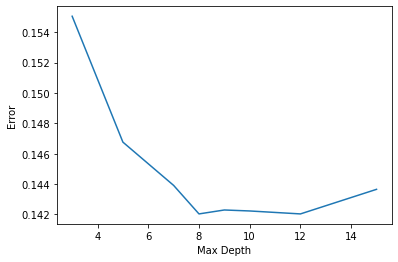

In [60]:
errors=[]
range_n = [3,5,7,8,9,10,12,15]

for n in range_n:
    model = xgb.XGBClassifier(booster = 'dart', n_estimators = 95 , min_child_weight = 3, max_depth = n, learning_rate = 0.1, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    errors.append(1-accuracy_score(y_test,pred))
    
plt.plot(range_n,errors)
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.show()

#### Plotting Learning Rate Vs Error 

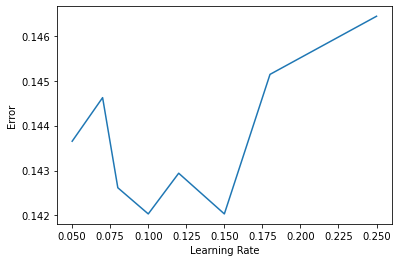

In [61]:
errors=[]
range_n = [0.05,0.07,0.08,0.1,0.12,0.15,0.18,0.25]

for n in range_n:
    model = xgb.XGBClassifier(booster = 'dart', n_estimators = 95 , min_child_weight = 3, max_depth = 8, learning_rate = n, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    errors.append(1-accuracy_score(y_test,pred))
    
plt.plot(range_n,errors)
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.show()

#### Plotting Number of Estimators Vs Error

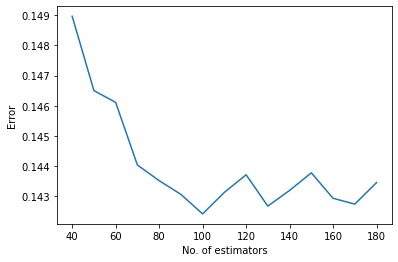

In [62]:
errors=[]
range_n = [40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]

for n in range_n:
    model = xgb.XGBClassifier(booster = 'dart', n_estimators = n , min_child_weight = 3, max_depth = 8, learning_rate = 0.1, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    errors.append(1-accuracy_score(y_test,pred))

plt.plot(range_n,errors)
plt.xlabel('No. of estimators')
plt.ylabel('Error')
plt.show()

#### Checking Validation Accuracy after Hyperparameter Tuning

In [63]:
model = xgb.XGBClassifier(booster = 'dart', n_estimators = 120 ,min_child_weight = 3, max_depth = 9, learning_rate = 0.1, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')

model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8579012105910533

### We get a Validation Accuracy of 85.8%

### Ploting the Feature Importance Graph

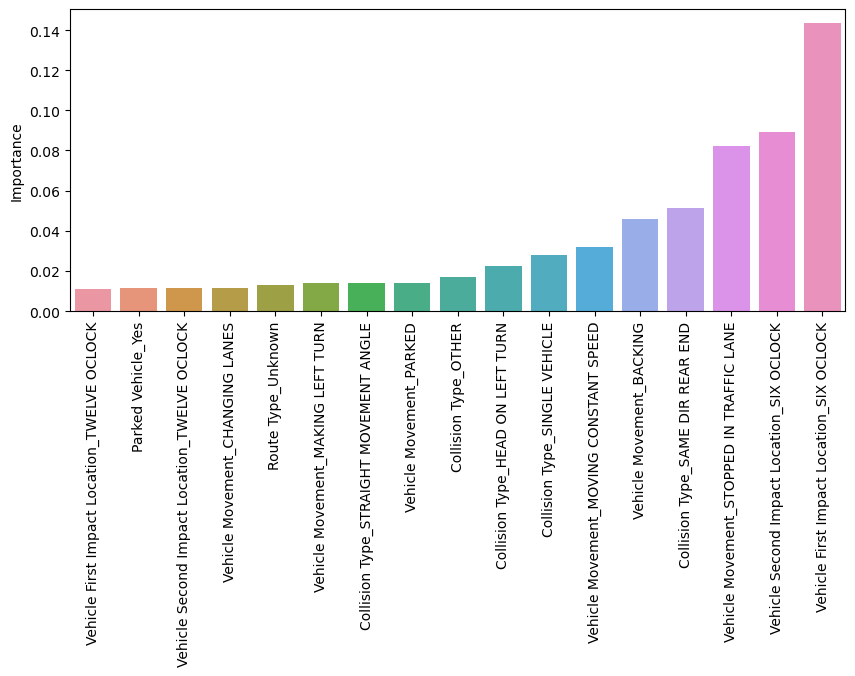

In [64]:
imp = pd.DataFrame(index = X.columns, data = model.feature_importances_, columns = ['Importance'])
imp = imp[imp['Importance'] > 0.01]

plt.figure(figsize=(10,4),dpi=100)
sns.barplot(data = imp.sort_values('Importance'), x = imp.sort_values('Importance').index, y = 'Importance')
plt.xticks(rotation=90)
plt.show()

In [65]:
y = df['Fault']

a = (np.intersect1d(df.columns, df_test.columns))

df_test = df_test.loc[:,a]
df= df.loc[:,a]

X = df

## Model is ready to be tested on the test data

In [66]:
model = xgb.XGBClassifier(booster = 'dart', n_estimators = 150, min_child_weight = 3, max_depth = 9, learning_rate = 0.1, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)
predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
predicted_df = predicted_df.reset_index()
predicted_df.columns = ['Id','Fault']
predicted_df.to_csv("submission.csv",index = False)

### Achieved a Testing Accuracy of 87.1% on Kaggle using a single model

## Running 5 models with different hyperparameters

In [67]:
model = xgb.XGBClassifier(booster = 'dart', n_estimators = 150, min_child_weight = 3, max_depth = 9, learning_rate = 0.1, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
# predicted_df.to_csv("hybrid1.csv")

#-------------------------------------------------------------------------------------------------------------------------

model = xgb.XGBClassifier(booster = 'dart', n_estimators = 150, min_child_weight = 3, max_depth = 8, learning_rate = 0.3, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
# predicted_df.to_csv("hybrid2.csv")

#-------------------------------------------------------------------------------------------------------------------------

model = xgb.XGBClassifier(booster = 'dart', n_estimators = 120, min_child_weight = 3, max_depth = 8, learning_rate = 0.4, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
# predicted_df.to_csv("hybrid3.csv")

#-------------------------------------------------------------------------------------------------------------------------

model = xgb.XGBClassifier(booster = 'dart', n_estimators = 180, min_child_weight = 3, max_depth = 9, learning_rate = 0.4, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
# predicted_df.to_csv("hybrid4.csv")

#-------------------------------------------------------------------------------------------------------------------------

model = xgb.XGBClassifier(booster = 'dart', n_estimators = 80, min_child_weight = 3, max_depth = 9, learning_rate = 0.3, 
                          gamma = 0.5, colsample_bytree = 0.4, eta = 0.1, reg_lambda = 0.2,reg_alpha = 0, scale_pos_weight = 1,
                         eval_metric = 'logloss')
model.fit(X, y)
pred = model.predict(df_test)

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = pred
# predicted_df.to_csv("hybrid5.csv")

#-------------------------------------------------------------------------------------------------------------------------

## In order to Push the Accuracy even higher and to get to the top of the leaderboards, we have taken 5 of our best accuracy models and did a majority voting(similar idea as random forests)

In [68]:
sub1 = pd.read_csv('Top 5 CSV/1.csv')
sub_f1 = sub1['Fault']

sub2 = pd.read_csv('Top 5 CSV/2.csv')
sub_f2 = sub2['Fault']

sub3 = pd.read_csv('Top 5 CSV/3.csv')
sub_f3 = sub3['Fault']

sub4 = pd.read_csv('Top 5 CSV/4.csv')
sub_f4 = sub4['Fault']

sub5 = pd.read_csv('Top 5 CSV/5.csv')
sub_f5 = sub5['Fault']


final = sub_f1 + sub_f2 + sub_f3 + sub_f4 + sub_f5 
final = final/5
final = final > 0.5
final = np.array(final, dtype = 'int')

predicted_df = pd.DataFrame({'Fault': pd.Series([], dtype='int')})

predicted_df['Fault'] = final
predicted_df = predicted_df.reset_index()
predicted_df.columns = ['Id','Fault']
predicted_df.to_csv("hybrid_submission.csv",index = False)
new = pd.read_csv('hybrid_submission.csv')
new

,Id,Fault
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
77230,77230,0
77231,77231,0
77232,77232,0
77233,77233,1


### By majority voting of 5 of our best models we have achieved an accuracy of 88.31% on the Test data